# DETERMINE R function of $\theta$

NOTA: t in ms

In [1]:
from labbiofisica import Interpolazione
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import os
import plotly.graph_objects as go 

In [2]:
# Carico i dati {θ: {x: [], y: []}}
# NOTA: sigmay = 0.001 per tutti i dati
data = {}

TETA = np.array([50,60,70,80,90,100,110,120,130])
GAMMA = []
sigmaGAMMA = []

# t convertito in secondi
for θ in TETA:
    filename = f'./data/g_{θ}.txt'
    θ = 180 - θ
    read = pd.read_csv(filename,sep='\t ',header=None,engine='python')
    read = read[(read[0] >= 0.1) & (read[0] <= 10)]
    data[θ] = {'t':read[0].to_numpy()/1000,'g':read[1].to_numpy(),'sigmag': np.float64(0.001)}

TETA = 180 - TETA

In [3]:
# Constants
n = 1.33
η = 10**-9  # g/(nm*s)
λ = 633  # nm
T = 293  # K
KB = 1.3806e-2  # g (nm)^2 / s K


In [4]:
# plot row data

fig = go.Figure()

# fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='data'))

fig.update_layout(
	xaxis_type="log",
	yaxis_title="g<sup>2</sup>(τ)",
	xaxis_title="t (ms)",
	title='g<sup>2</sup>(τ) vs t',
	xaxis=dict(range=[np.log10(0.0001), np.log10(0.01)]),
	# yaxis=dict(range=[0, 0.06])
)

for θ in data.keys():
	fig.add_trace(go.Scatter(x=data[θ]['t'], y=data[θ]['g'], mode='markers', name=f'θ={θ}°',error_y=dict( 
			type='constant', 
			value=0.001, 
			color='black',
			thickness=1.5, 
			width=3, 
		)))

fig.show()

In [5]:
# fit data


f = lambda x, A, B, γ: A*np.exp(-γ*x) + B

for key in data.keys():
    x = data[key]['t']
    y = data[key]['g']
    sigmay = data[key]['sigmag']
    m = Interpolazione(x, y, sigmay, f, [0.05, 0.001, 2.7],['A','B','γ'])
    data[key]['fit'] = m
    # print(m.values['γ'])
    data[key]['gamma'] = m.values['γ']
    GAMMA.append(m.values['γ'])
    sigmaGAMMA.append(m.errors['γ'])

GAMMA = np.array(GAMMA) 
sigmaGAMMA = np.array(sigmaGAMMA)

# print gamma teta:
gammateta = pd.DataFrame({'θ':TETA,'γ':GAMMA,'σγ':sigmaGAMMA})
display(gammateta)

,θ,γ,σγ
0,130,4371.401608,181.272346
1,120,4041.892054,155.063523
2,110,3504.513596,127.011402
3,100,3160.465913,102.062704
4,90,2634.144280,76.330465
5,80,2190.704671,58.424413
6,70,1699.011400,44.416291
7,60,1286.554733,32.391719
8,50,861.021581,20.172900


# PLOT FIT

In [6]:
colors = px.colors.qualitative.D3

fig = go.Figure()
for i,θ in enumerate(data.keys()):
    x = data[θ]['t']
    y = data[θ]['g']
    γ = data[θ]['gamma']
    sigmay = data[θ]['sigmag']
    X,Y = data[θ]['fit'].draw()

    # plt.plot(X,Y)
    # plt.xlim(0,1)
    # plt.show()

    fig.add_trace(go.Scatter(x=X, y=Y, mode='lines',line_color=colors[i], showlegend=False))

    fig.add_trace(go.Scatter(x=x,y=y, mode='markers', name=f'θ={θ}°',
        marker=dict(color = colors[i]),
        error_y=dict( 
			type='constant', 
			value=0.001, 
			color=colors[i],
			thickness=1.5, 
			width=3, 
		)))

fig.update_layout(
        xaxis_type="log",
        yaxis_title="g<sup>2</sup>(τ)",
        xaxis_title="t (s)",
        title='g<sup>2</sup>(τ) vs t',
        xaxis=dict(range=[np.log10(0.0001), np.log10(0.010)]),
        width=800,
        height=600,
        # yaxis=dict(range=[0, 0.06])
    )
fig.show()

$Q = \frac{4\pi n}{\lambda}\sin\frac{\theta}{2}$

$\gamma = 2DQ^2 \Rightarrow D = \frac{\gamma\lambda^2}{32\pi^2n^2\sin^2\frac{\theta}{2}}$

$D = \frac{K_B T}{6\pi\eta\R}$

$R = \frac{16\pi n^2 K_B T}{3\eta\lambda^2\gamma}\sin^2\frac{\theta}{2}$

n = 1.33

$\eta$ = 0.01poise

$\lambda$ = 633nm

$K_B$ = $$

T = 293K

----------------- VALORI FIT: -----------------
D: (3.705 ± 0.036)e6 

dof: 8
chi2: 14.09
chi2 ridotto: 1.76
pvalue: 0.08
------------------------------------------------



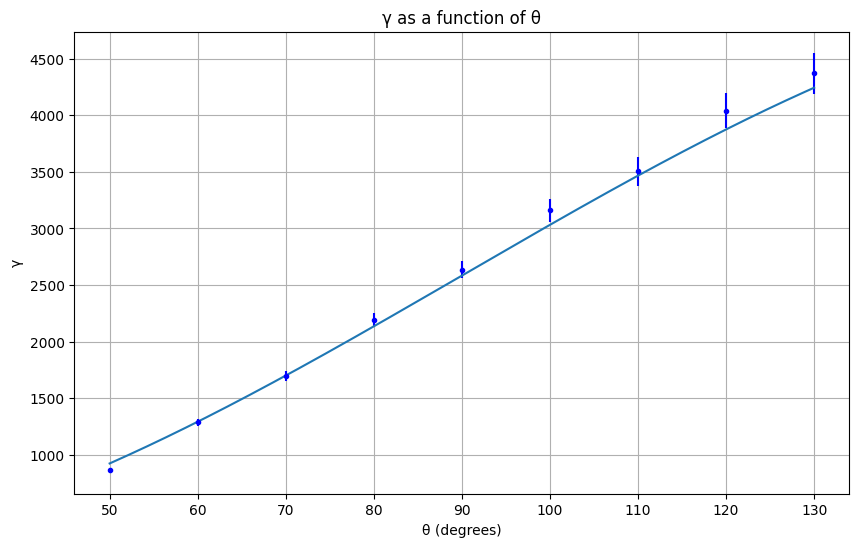

In [7]:
plt.figure(figsize=(10, 6))
plt.errorbar(TETA, GAMMA,yerr=sigmaGAMMA, marker='.', linestyle='None', color='b')
plt.xlabel('θ (degrees)')
plt.ylabel('γ')
plt.title('γ as a function of θ')
plt.grid(True)


# fit gamma teta

def gamma_2DQ2(θ,D):
    theta = np.deg2rad(θ)
    return 2*D*16*(np.pi**2)*(n**2)*np.sin(theta/2)**2/(λ**2)

gammatetafit = Interpolazione(TETA, GAMMA, sigmaGAMMA, gamma_2DQ2, [0.05],['D'])
print(gammatetafit)

plt.plot(gammatetafit.draw()[0],gammatetafit.draw()[1])

plt.show()

In [8]:
# real_gamma = GAMMA*1000 # TODO: check this
def calculate_R(gamma, theta):
    theta_rad = np.radians(theta)
    R = (16 * np.pi * n**2 * T * KB * np.sin(theta_rad / 2)**2) / (3 * η * λ**2 * gamma)
    return R

# Calculate R for each gamma and theta
R_values = [calculate_R(gamma, theta) for gamma, theta in zip(GAMMA, TETA)]
R_values_df = pd.DataFrame({'θ (deg)': TETA, 'R (nm)': R_values})
display(R_values_df)

,θ (deg),R (nm)
0,130,56.222567
1,120,55.520901
2,110,57.290319
3,100,55.556743
4,90,56.795038
5,80,56.432737
6,70,57.938369
7,60,58.142231
8,50,62.067240
